<img src="https://raw.githubusercontent.com/antfarol/wineClustering/master/images/QuiniLogo.png" alt="drawing" width="200"/>

#   QUINI WINE DATA clustering

[Data and problem outlined](#Data-and-problem-outlined) <br>
[Read and inspect the data](#Read-and-inspect-the-data) <br>
[Hierarchical clustering](#Hierarchical-clustering) <br>
[K-means](#K-means) <br>
[Clusters exploration and outcomes](#Clusters-exploration-and-outcomes)

## Data and problem outlined

[Quini](https://quiniwine.com) is a start-up company which provides the app that allows to teste wines and evaluate up to 30 different data points - sensory and attitudional aspects of a wine.
For instanse sweetness, acidity, tannins, alcohol, aftertaste duration, nose complexity, pick different flavours and aromas and so on.
Random users can build up their wine portfolio and share wine reviews. <br>

Quini also sets up wine testing groups and events and engages winemakers to evaluate their products in a panel against other producers.<br>
The question I was asked was _'What potential opportunities, product segments we can highlight and share with wine producers based on this data?'_

Since it was kind of an open ended question, referring hidden segments I decided to go with __unsuperwised learning, clustering__ and then inspect the segments for unusual/interesting outcomes and patterns.

The platform and the app is relatively new so the data I was able to get was not tremendously big. It is roughly 13K reviews for ~450 wines from ~1100 users. This could be a chellange as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
# plt.rcParams.update({'font.size': 20})

## Read and inspect the data

### Main data

In [2]:
df=pd.read_csv('clustData.csv')
print('Data has information about', len(df), 'wines')
print('Each row has', len(df.columns), 'columns')

Data has information about 444 wines
Each row has 20 columns


In [3]:
df.columns

Index(['Product Name', 'Varietal', 'Type', 'Number of Records', 'Eye.Col',
       'Eye.Appeal', 'Nose.Appeal', 'Nose.Complexity', 'Mouth.Sw', 'Mouth.Tan',
       'Mouth.Acid', 'Mouth.Alc', 'Mouth.Complexity', 'Mouth.App',
       'Finish.Dur', 'Finish.Qual', 'Finish.Peak', 'Finish.Appeal',
       'Finish.Comp', 'Total Score'],
      dtype='object')

In [3]:
df.tail()

,Product Name,Varietal,Type,Number of Records,Eye.Col,Eye.Appeal,Nose.Appeal,Nose.Complexity,Mouth.Sw,Mouth.Tan,Mouth.Acid,Mouth.Alc,Mouth.Complexity,Mouth.App,Finish.Dur,Finish.Qual,Finish.Peak,Finish.Appeal,Finish.Comp,Total Score
439,Wine O'Clock Shiraz 750ml,Shiraz,Red,13,48.69,80.08,78.54,53.23,46.85,56.85,43.62,53.38,52.62,78.00,40.38,46.15,45.31,81.00,53.46,76.62
440,Winemaker's House Pinot Grigio NV,Pinot Grigio,White,51,34.39,77.90,67.76,45.86,50.24,56.69,50.63,47.06,47.98,68.39,39.92,43.98,37.25,68.29,44.96,67.14
441,Woodbridge by Robert Mondavi White Zinfandel 2017,Zinfandel,Rose,46,62.89,81.48,77.35,46.54,87.35,41.13,54.43,33.24,46.72,75.89,41.59,48.61,39.86,75.78,44.74,75.00
442,Yellow Tail Bubbles NV,White Blend,White,23,46.00,77.61,70.52,44.13,55.04,46.50,66.52,32.35,34.57,69.78,42.91,51.68,35.74,75.00,39.22,70.48
443,Yellow Tail Chardonnay 2018,Chardonnay,White,7,43.71,74.86,81.86,47.86,43.67,27.43,43.43,32.43,46.29,65.86,28.00,47.29,40.14,68.00,48.71,70.71


As we see for each wine we have many different sensory aspects like _Eye Colour, Nose Complexity, Mouth Sweetness, Mouth Tannins, Finish Peak and so on_. We also have some columns which we hardly can use as a features for clustering. For example Varietal and Type have already represent natural clusters and will only mislead the algorithm. Also I will drop Number of Records - which is the total number of reviews for a particular product, as well as Total Score which is aggregation of the four other aspects - Eye Appeal (overall measure for the liquid in the glass), Nose Appeal (overall for the aroma), Mouth Appeal, and Finish Appeal.

### Number of Reviews

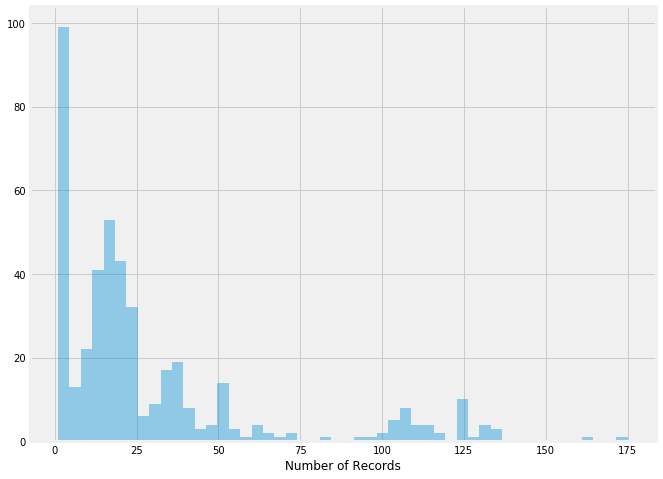

In [4]:
plt.figure(figsize=(10,8))
ax=sns.distplot(df['Number of Records'], kde=False, bins=50)

Around 100 wines in our data has only 1 or 2 Reviews. The majority of products has around 20 reviews, some of them - 100+<br>
Let's see how the number of reviews affects average Total Score. Total Score is a key 'target' metric during the testing.

### Number fo reviews~total score

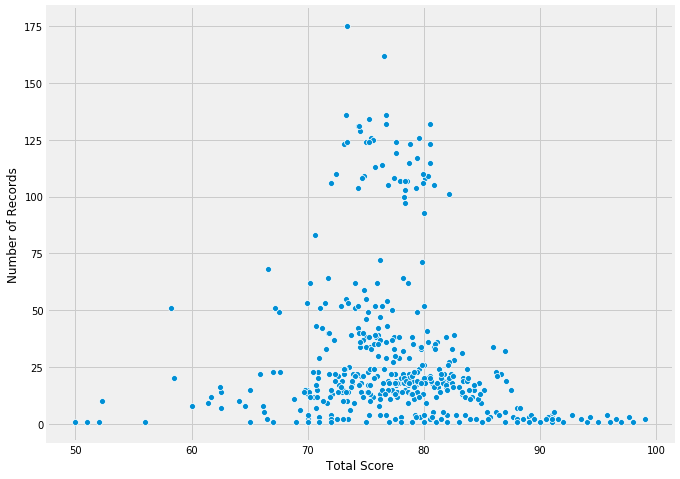

In [5]:
plt.figure(figsize=(10,8))
ax=sns.scatterplot(y='Number of Records', x='Total Score', data=df)

We can see the Law of Large Numbers in action. When the # reviews is low - Total Score is highly volatile. When there is enough reviews Total Score is whithin some reasonable range.

### Number of records by Type

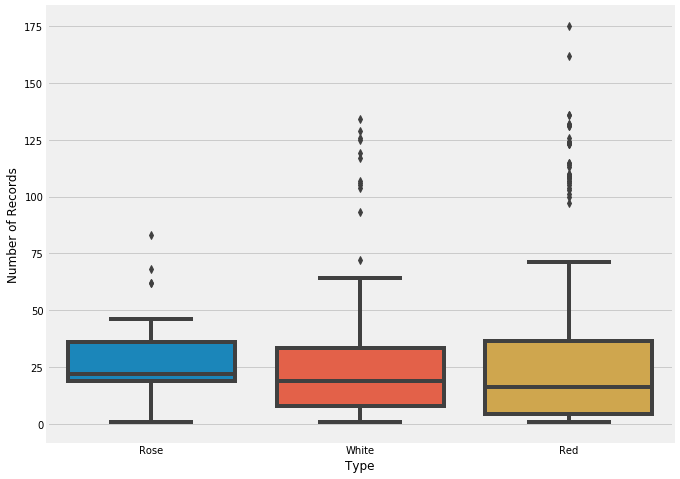

In [6]:
plt.figure(figsize=(10,8))
ax=sns.boxplot(x='Type', y='Number of Records', data=df)

### Number fo reviews~Sweetness

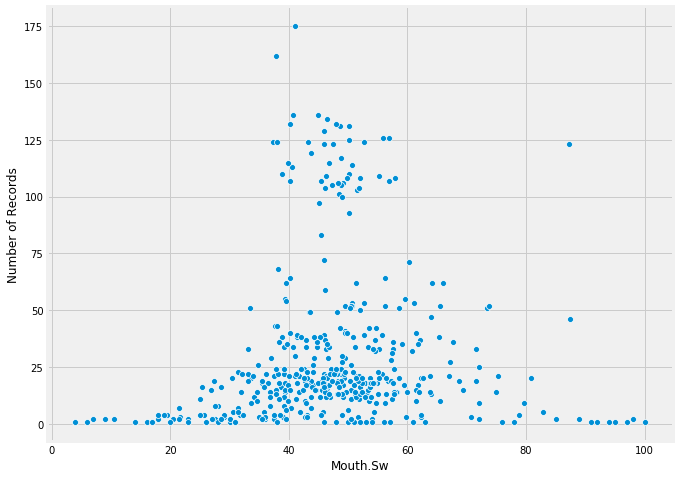

In [7]:
plt.figure(figsize=(10,8))
ax=sns.scatterplot(y='Number of Records', x='Mouth.Sw', data=df)

The same with other features - the higher the number of reviews the lower variation of a feature

For my model __I will keep only products with >= 5 reviews__. I tried different options here and believe this is the optimal way.<br>
I also will drop non-feature columns and store clustering features in a separete dataframe

In [9]:
df=df[df['Number of Records'] >=5]
data=df.drop(['Product Name', 'Varietal', 'Type', 'Number of Records', 'Total Score'], axis=1)

### Aroma and Flavour data

During the review a user can evaluate aroma and flavour for a particular wine and pick up to 7 layers of each out of 100 different aroma/flavour options. Like Mint, Peach, Rose, Raspberry, Blue Cheese and so on.

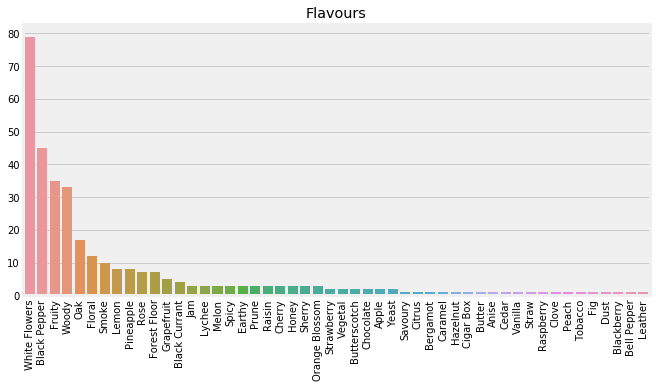

In [10]:
elem=pd.read_csv('elements.csv')
elem.head()

elem=elem[elem['element result'] != ' ']

# keep only wines with have >=5 reviews
elem = elem[elem['Product Name'].isin(df['Product Name'])]
len(elem['Product Name'].value_counts())

# top flavours/aromas
top_elem=elem.sort_values('Number', ascending=False).groupby(['Product Name', 'class']).head(4) # can try top3!
pd.crosstab(top_elem['Product Name'], top_elem['class'])

top_elem.head()
top_elem['ord']=top_elem.groupby(['Product Name', 'class']).cumcount() + 1
top_elem=top_elem.sort_values(['Product Name', 'class', 'ord'])

top_elem['class_n']=top_elem['class']+top_elem['ord'].map(str)

top_elem=top_elem.pivot(index='Product Name', columns='class_n', values='element result')
top_elem.reset_index(level=0, inplace=True)

# top flavours
p=top_elem['Flavour1'].value_counts()
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.title('Flavours')
ax=sns.barplot(x=p.index, y=p.values)

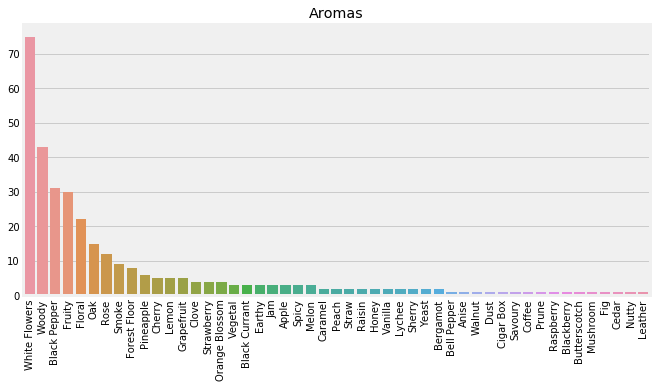

In [11]:
# top aromas
p=top_elem['Aroma1'].value_counts()
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.title('Aromas')
ax=sns.barplot(x=p.index, y=p.values)

_White Flowers_ is the most popular Aroma and Flavour followed by _Black Papper, Frutty, Woody_ and so on. Some reviews might have all 7 layers for aroma/flavour some only 1.<br> 

Initially I took top 2 aromas/flavours for a particular wine and included this into features. But algorithms were very sensetive to this features and split wines in clusters with _White Flower_ aroma and whithout it. So I desided to keep these features aside and then take a look which clusters will come out with what aromas/flacours.

In [12]:
top_elem.head()

class_n,Product Name,Aroma1,Aroma2,Aroma3,Aroma4,Flavour1,Flavour2,Flavour3,Flavour4
0,14 Hands 'Hot to Trot' Red 2016,Spicy,Clove,Black Pepper,Woody,Black Pepper,Spicy,Clove,Woody
1,14 Hands 'Run Wild' Red 2017,Clove,Oak,Jam,Black Pepper,Black Pepper,Clove,Jam,Smoke
2,14 Hands 'Stampede' Red 2015,Black Pepper,Sherry,Woody,Earthy,Black Pepper,Woody,Oak,Sherry
3,14 Hands Cabernet Sauvignon 2016,Forest Floor,White Flowers,Black Pepper,Clove,Black Pepper,White Flowers,Forest Floor,Clove
4,19 Crimes 'The Uprising' 2017,Sherry,Blackberry,Butter,Cheese,Blackberry,Sherry,Vanilla,Nutty


### Distribution of the features

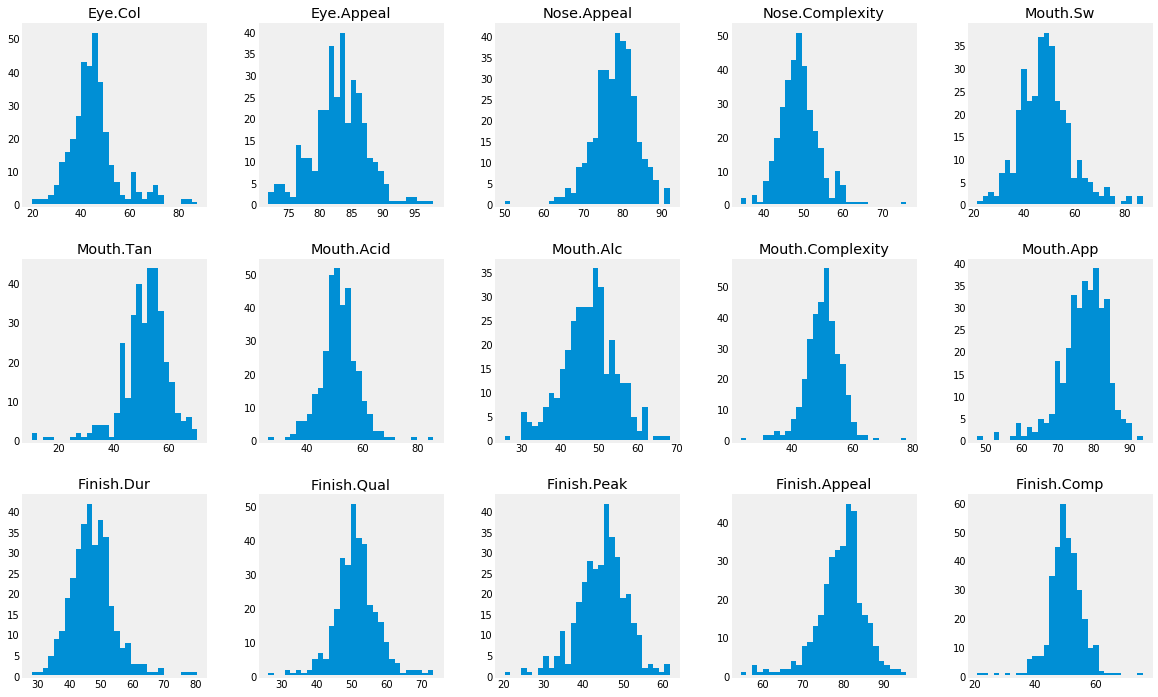

In [13]:
fig, axes = plt.subplots(3, len(data.columns)//3, figsize=(18, 12))

i = 0
for triaxis in axes:
    for axis in triaxis:
#        sns.distplot(data[i], ax=axis)
#        axis.set_xlabel("")
        data.hist(column = data.columns[i], bins = 30, ax=axis, grid=False)
        i = i+1

### Scalinig

As we can see all features are close to t-distribution. Anyway I desided to scale and normalize to eliminate skewness and set the same scale.

In [14]:
from sklearn import preprocessing

In [15]:
data_norm=preprocessing.normalize(data)
data_norm=preprocessing.scale(data_norm)

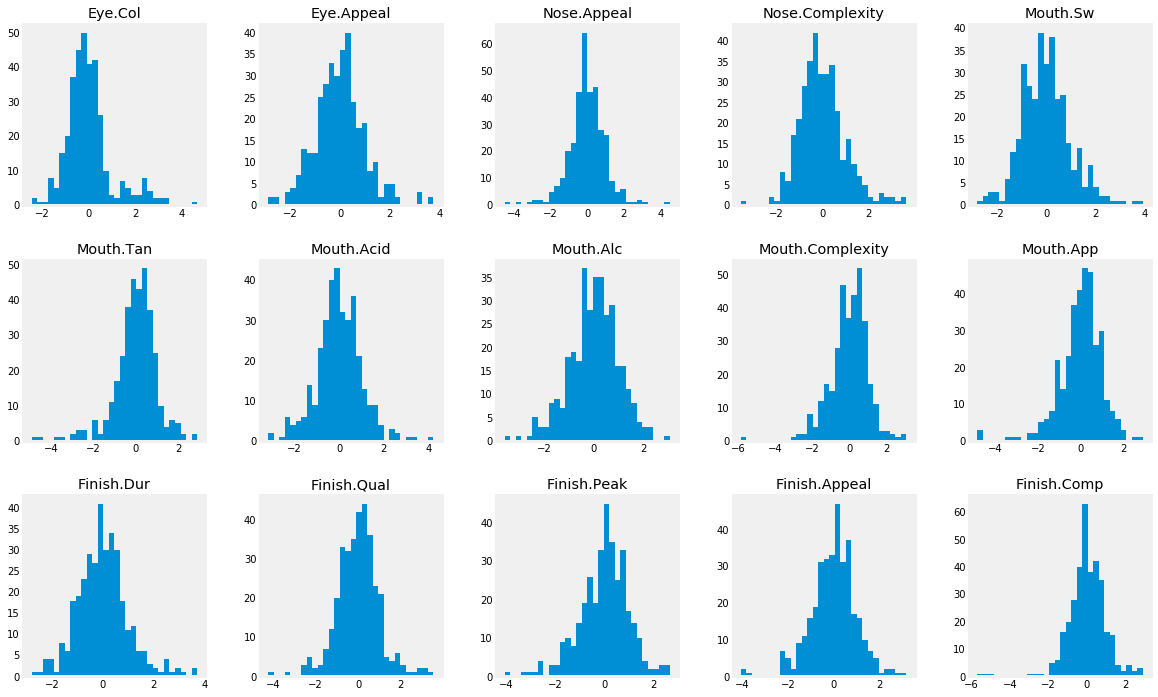

In [16]:
data_norm_df=pd.DataFrame(data=data_norm, columns=data.columns)
fig, axes = plt.subplots(3, len(data_norm_df.columns)//3, figsize=(18, 12))
i = 0
for triaxis in axes:
    for axis in triaxis:
        data_norm_df.hist(column = data_norm_df.columns[i], bins = 30, ax=axis, grid=False)
        i = i+1

### SVD

I also decided to apply SVD and use principal components for clustering. Using all the features makes data preaty nosy and algorithm can't find distinct clusters.
I tryed different options and desided to go with top 5 PC which explain 67% of the variation.

In [17]:
from sklearn.decomposition import TruncatedSVD

In [18]:
lsa=TruncatedSVD(5, algorithm='arpack', random_state=2)
data_lsa=lsa.fit_transform(data_norm)
lsa.explained_variance_ratio_.sum()

0.668528211189416

In [19]:
data_norm=data_lsa

## Hierarchical clustering

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

In [21]:
link=linkage(data_norm, 'ward', 'euclidean')

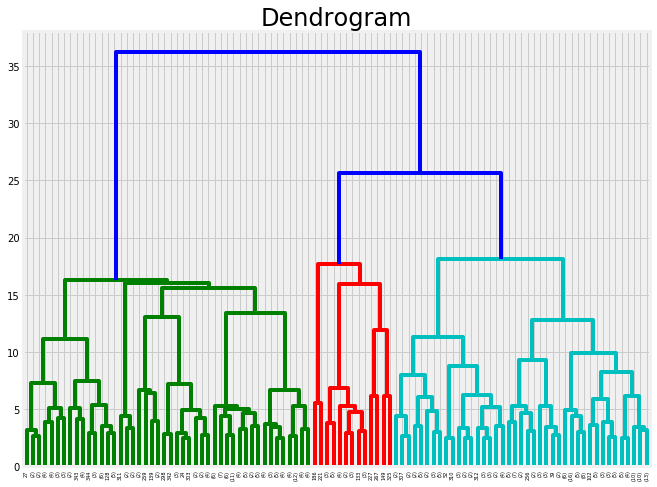

In [22]:
threshold=22

plt.figure(figsize=(10, 8))
plt.title('Dendrogram', fontsize=24)
dn=dendrogram(link, 
              truncate_mode='lastp',
              p=100,
#               orientation='right', 
              color_threshold=threshold)

### Distances between clusters - optimal number of clusters

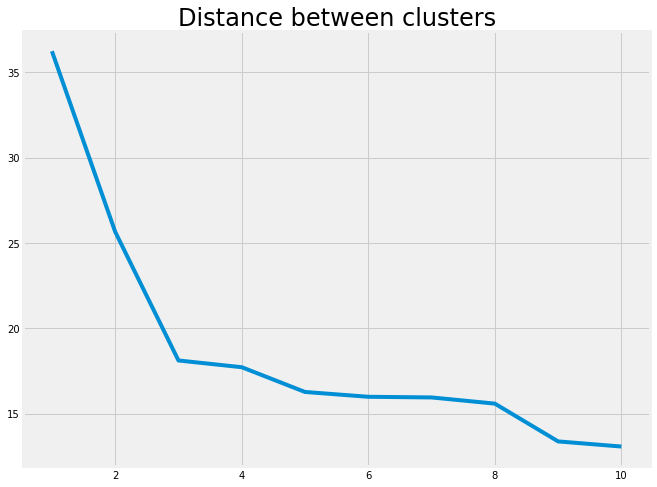

In [24]:
last = link[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

plt.figure(figsize=(10,8))
plt.plot(idxs, last_rev)
plt.title('Distance between clusters', fontsize=24)

plt.show()

>__We have 3 clusters__

Let's plot clusters in the two first PC axis

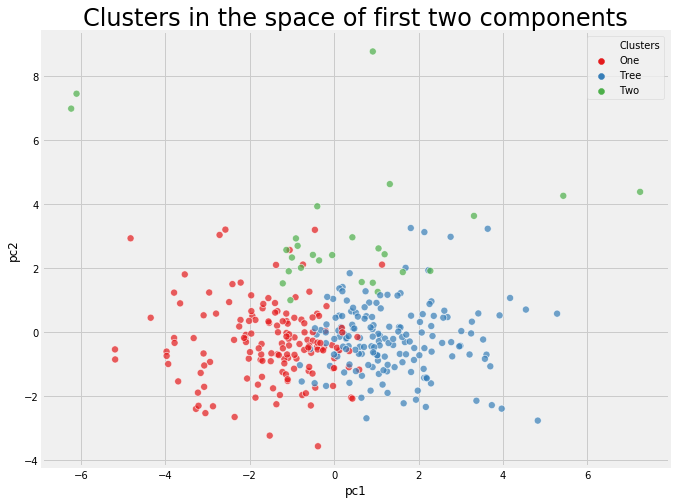

In [25]:
data_norm_svd=pd.DataFrame(data=data_norm, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
data_norm_svd['cluster']=fcluster(link, threshold, criterion='distance')
data_norm_svd['Clusters'] = np.where(data_norm_svd['cluster']==1, 'One', np.where(data_norm_svd['cluster']==2,'Two','Tree'))
data_norm_svd['Total Score'] = df['Total Score']
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Clusters in the space of first two components', fontsize=24)
ax=sns.scatterplot(x='pc1', y='pc2', hue='Clusters', 
                   data=data_norm_svd, s=50,
                   palette="Set1",
                   alpha=0.7)

## K-means

I tried k-means as a traditional approach to compeare results

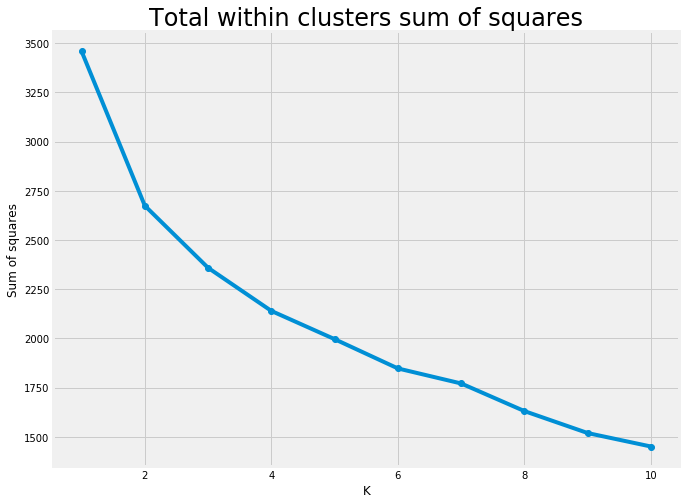

In [27]:
from sklearn.cluster import KMeans

K=range(1, 11)
models=[KMeans(n_clusters=k, random_state=42).fit(data_norm) for k in K]

dist=[model.inertia_ for model in models]

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Total within clusters sum of squares', fontsize=24)
plt.plot(K, dist, marker='o')
plt.xlabel('K')
plt.ylabel('Sum of squares')
plt.show()

> __K-means can not recognise clusters__

## Clusters exploration and outcomes

Number of elements by cluster

In [28]:
data['cluster']=fcluster(link, threshold, criterion='distance')
df['cluster'] =data['cluster']
df['cluster'].value_counts()

3    164
1    154
2     27
Name: cluster, dtype: int64

### Let's compare clusters against Types

In [29]:
p=df.groupby(['cluster', 'Type']).agg({'Product Name':'count'})
p.reset_index(inplace=True)
pd.pivot_table(p, values='Product Name', index=['Type'], columns='cluster')

cluster,1,2,3
Type,,,
Red,30,6,131
Rose,14,17,2
White,110,4,31


1 st cluster has the majority of White wines, the second - Rose and the 3dr - Red

> **Looks like the data inherits the information about the Type of the wine and algorithm was able to recognise it**

### Distribution of sensory features by cluster

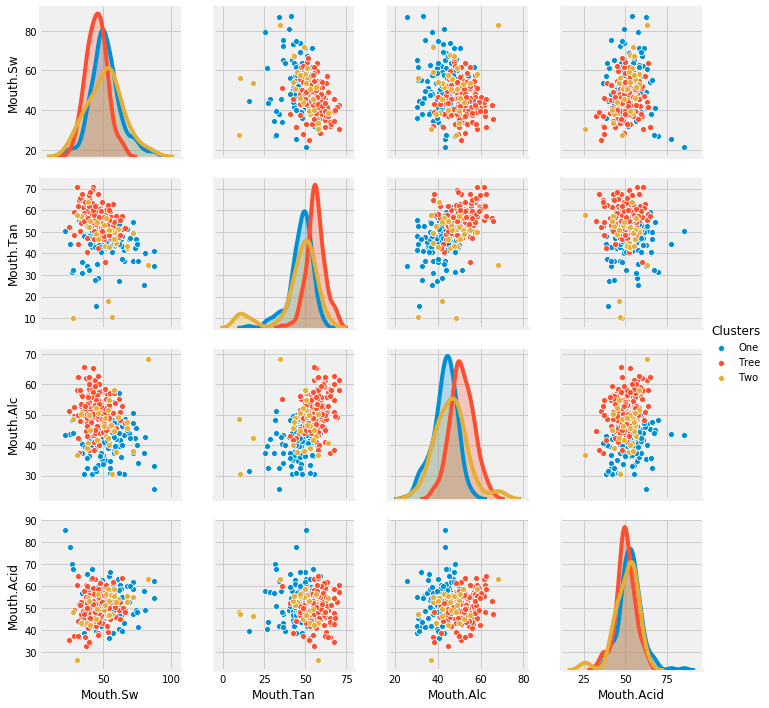

In [48]:
df['Clusters'] = np.where(df['cluster']==1, 'One', np.where(df['cluster']==2,'Two','Tree'))
ax=sns.pairplot(df[['Mouth.Sw', 'Mouth.Tan', 'Mouth.Alc', 'Mouth.Acid', 'Clusters']], 
             hue="Clusters")

3rd cluster has higher alcohol, tannins and lower sweetness (Red). While 1st clust is lower on alcohol and sweeter

### Distribution of all features by cluster

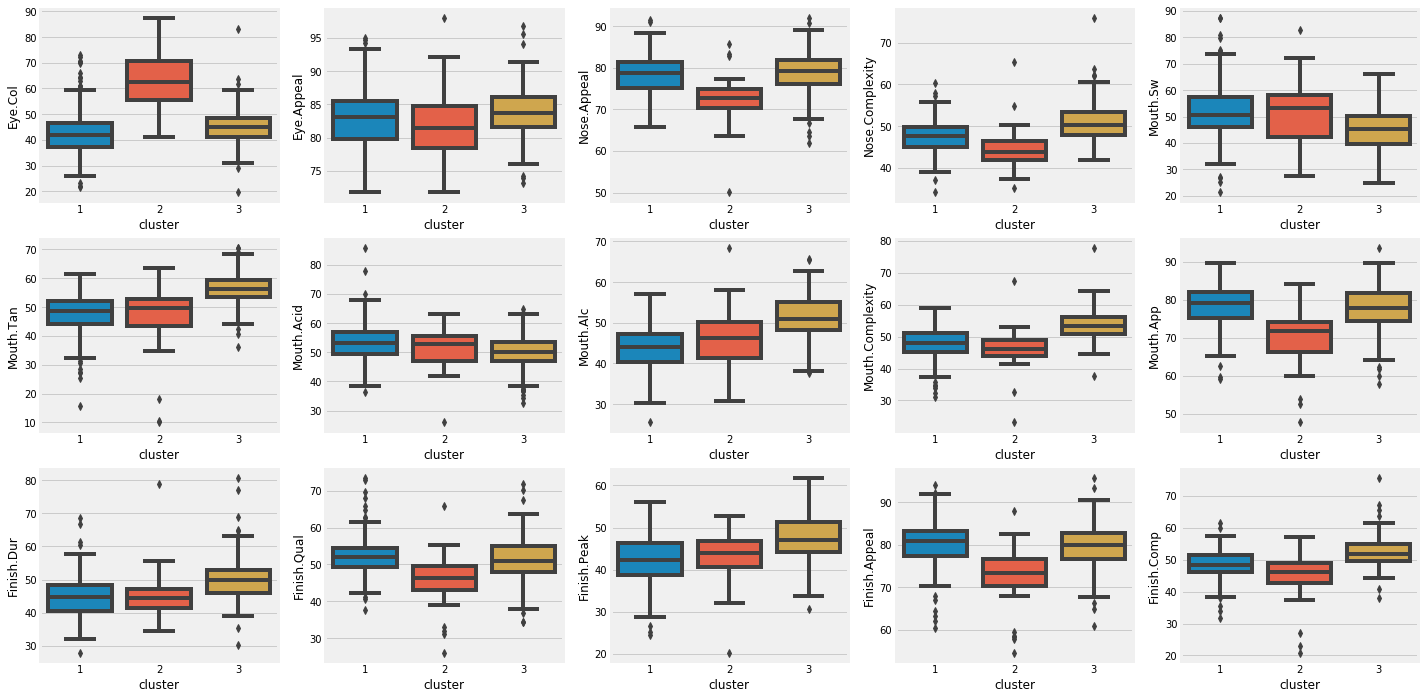

In [49]:
fig, axes = plt.subplots(3, len(data.columns)//3, figsize=(22, 12))

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.boxplot(x='cluster', y=data.columns[i], data=data, ax=axis)
        i = i+1

### Let's inspect most populated varietals

In [33]:
top_var=df[df['Varietal'].isin(['Chardonnay', 
                       'Pinot Noir', 
                      # 'Red Blend', 
                       'Cabernet Sauvignon', 
                       'Pinot Grigio',
                       'Pinot Gris'])]
    
top_var=top_var.assign(var = ['Pinot Gris' if a == 'Pinot Grigio' 
                              else a for a in top_var['Varietal']])

In [34]:
p=top_var.groupby(['cluster', 'var']).agg({'Product Name':'count', 'Total Score':np.mean})
p.reset_index(inplace=True)
p

,cluster,var,Product Name,Total Score
0,1,Cabernet Sauvignon,9,80.082222
1,1,Chardonnay,24,76.522917
2,1,Pinot Gris,24,75.499167
3,1,Pinot Noir,10,74.801000
4,2,Chardonnay,1,70.800000
5,2,Pinot Noir,2,73.200000
6,3,Cabernet Sauvignon,21,78.199524
7,3,Chardonnay,15,74.534667
8,3,Pinot Gris,4,70.335000
9,3,Pinot Noir,26,76.233846


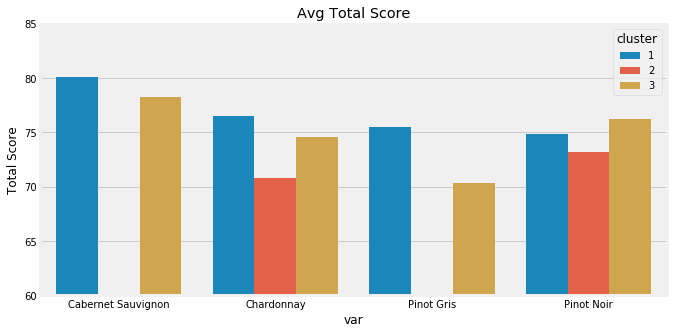

In [47]:
plt.figure(figsize=(10,5))
plt.ylim(60, 85)

ax=sns.barplot(x='var', y='Total Score', hue='cluster', data=p).set_title('Avg Total Score')

> __In most cases Varetal has higher Total Score when it falls into 'proper' cluster__

Cab Sauv - is opposite. 
Products in 'white' cluster (1sr) have higher score

### Add aromas and flavours

In [36]:
df=df.merge(top_elem, on='Product Name', how='left')

In [37]:
df.head()

,Product Name,Varietal,Type,Number of Records,Eye.Col,Eye.Appeal,Nose.Appeal,Nose.Complexity,Mouth.Sw,Mouth.Tan,...,cluster,Clusters,Aroma1,Aroma2,Aroma3,Aroma4,Flavour1,Flavour2,Flavour3,Flavour4
0,8th Generation Confidence Frizzante,"Pinot Noir, Pinot Gris",Rose,20,70.75,90.25,85.75,53.45,80.85,40.00,...,1,One,Floral,Fruity,Fig,Grapefruit,Fruity,Floral,White Flowers,Butterscotch
1,8th Generation Integrity Frizzante VQA,"Chardonnay, Pinot Gris, Kerner",White,20,33.75,85.50,78.80,45.30,62.20,47.20,...,1,One,Pineapple,Floral,Rose,Orange Blossom,Floral,Pineapple,Fruity,White Flowers
2,14 Hands 'Hot to Trot' Red 2016,Red Blend,Red,124,48.87,80.99,76.22,48.14,43.16,53.75,...,3,Tree,Spicy,Clove,Black Pepper,Woody,Black Pepper,Spicy,Clove,Woody
3,14 Hands 'Run Wild' Red 2017,Red Blend,Red,136,42.33,81.60,74.73,46.35,44.91,53.61,...,3,Tree,Clove,Oak,Jam,Black Pepper,Black Pepper,Clove,Jam,Smoke
4,14 Hands 'Stampede' Red 2015,Red Blend,Red,124,41.19,86.64,78.27,50.29,37.40,57.22,...,3,Tree,Black Pepper,Sherry,Woody,Earthy,Black Pepper,Woody,Oak,Sherry


### Investigate Cab Sauv

In [38]:
cabs=df[df['Varietal'] == 'Cabernet Sauvignon']

# cabs.groupby(['cluster', 'Flavour1']).agg({'Product Name': 'count'}).sort_values(['cluster','Product Name'],ascending=False)
cabs1=cabs[cabs['cluster'] == 1]['Product Name']
cabs3=cabs[cabs['cluster'] == 3]['Product Name']

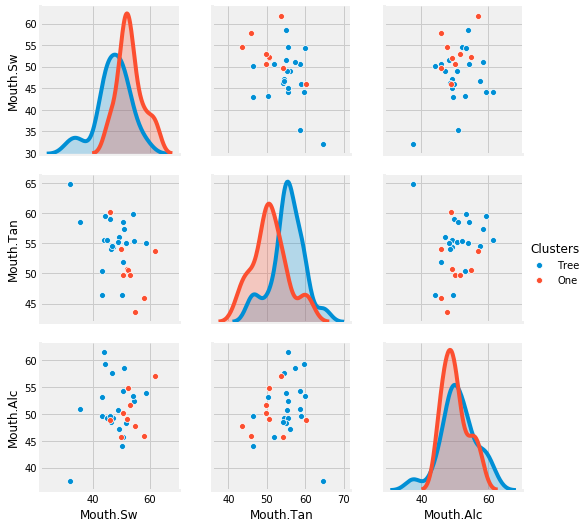

In [41]:
ax = sns.pairplot(cabs[['Mouth.Sw', 'Mouth.Tan', 'Mouth.Alc', 'Clusters']], 
             hue="Clusters")

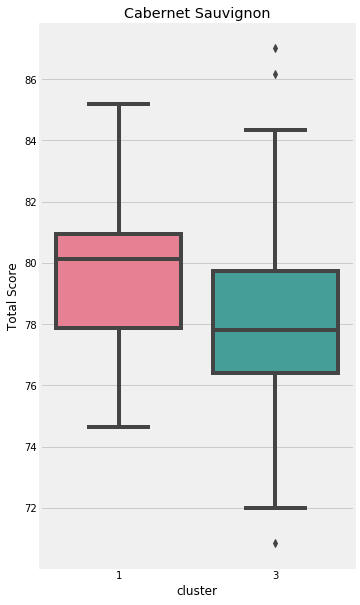

In [42]:
plt.figure(figsize=(5,10))
plt.title('Cabernet Sauvignon')
ax=sns.boxplot(x='cluster', y='Total Score', data=cabs, palette='husl')

### Compare top aromas and flavours

In [43]:
from wordcloud import WordCloud

In [44]:
cabs1=top_elem[top_elem['Product Name'].isin(cabs1)]
cabs3=top_elem[top_elem['Product Name'].isin(cabs3)]

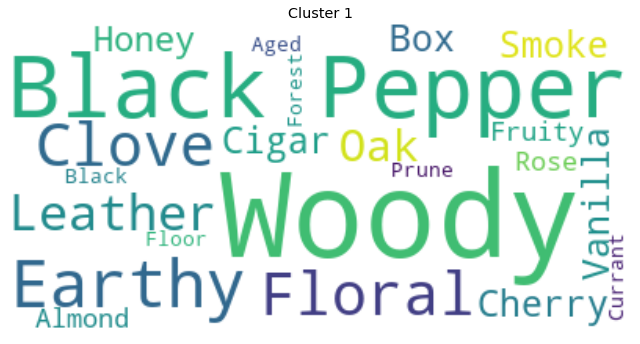

In [45]:
cabs1=pd.melt(cabs1, id_vars=['Product Name'], value_vars=['Flavour1', 'Flavour2', 'Flavour3', 'Aroma1', 'Aroma2', 'Aroma3'])
wordcloud2 = WordCloud(background_color="white").generate(' '.join(cabs1['value']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title("Cluster 1")
plt.axis("off")
plt.show()

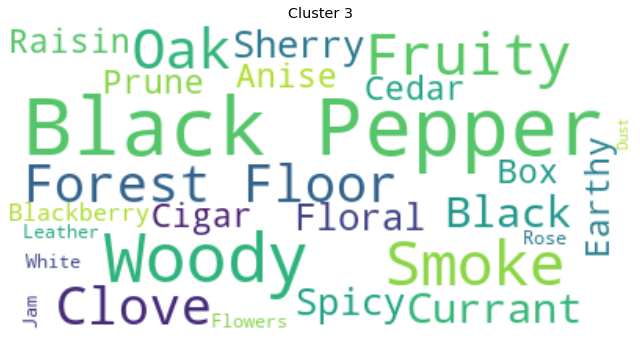

In [46]:
cabs3=pd.melt(cabs3, id_vars=['Product Name'], value_vars=['Flavour1', 'Flavour2', 'Flavour3', 'Aroma1', 'Aroma2', 'Aroma3'])
wordcloud2 = WordCloud(background_color="white").generate(' '.join(cabs3['value']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title("Cluster 3")
plt.axis("off")
plt.show()